In [1]:
%matplotlib inline
from pycocotools.coco import COCO
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import os
import pylab
import skimage.io as io
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

C:\Users\Mohamed Habib\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
train_dir = 'C:/Users/Mohamed Habib/Documents/AI Summative Project/coco/train2017'
train_anns = 'C:/Users/Mohamed Habib/Documents/AI Summative Project/coco/annotations/instances_train2017.json'

test_dir = 'C:/Users/Mohamed Habib/Documents/AI Summative Project/coco/test2017'

val_dir = 'C:/Users/Mohamed Habib/Documents/AI Summative Project/coco/val2017'
val_anns = 'C:/Users/Mohamed Habib/Documents/AI Summative Project/coco/annotations/instances_val2017.json'

In [3]:
train_process_dir = "C:/Users/Mohamed Habib/Documents/AI Summative Project/processed/train2017_P"
os.makedirs(train_process_dir, exist_ok=True)

val_process_dir = "C:/Users/Mohamed Habib/Documents/AI Summative Project/processed/val2017_P"
os.makedirs(val_process_dir, exist_ok=True)

In [4]:
coco_train = COCO(train_anns)

loading annotations into memory...
Done (t=19.74s)
creating index...
index created!


In [5]:
coco_val = COCO(val_anns)

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


In [6]:
target_shape = (416, 416)

In [7]:
def padding(image, target_shape):
    # Calculate the target size for resizing while maintaining aspect ratio
    height, width, _ = image.shape
    target_width, target_height = target_shape
    aspect_ratio = width / height

    if aspect_ratio > 1:  # Landscape image
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
    else:  # Portrait image
        new_height = target_height
        new_width = int(new_height * aspect_ratio)

    # Resize the image while maintaining aspect ratio
    resized_image = cv2.resize(image, (new_width, new_height))

    # Create an empty canvas with the target shape
    canvas = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    # Calculate the position to paste the resized image
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image

    return canvas


def preprocess_images(coco, images_dir, output_dir):
    image_ids = coco.getImgIds()

    for img_id in tqdm(image_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(images_dir, img_info['file_name'])
        image = cv2.imread(img_path)

        # Resize image while maintaining aspect ratio and adding padding
        padded_image = padding(image, target_shape)

        # Normalize pixel values to be in the range [0, 1]
        padded_image = padded_image / 255.0

        # Save processed image
        output_path = os.path.join(output_dir, img_info['file_name'])
        cv2.imwrite(output_path, (padded_image * 255).astype(np.uint8))

In [121]:
preprocess_images(coco_train, train_dir, train_process_dir)

100%|██████████████████████████████████████████████████████████████████████████| 118287/118287 [34:17<00:00, 57.48it/s]


In [129]:
preprocess_images(coco_val, val_dir, val_process_dir)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:39<00:00, 50.48it/s]


In [20]:
# Get image IDs and corresponding annotations for training set
train_image_ids = coco_train.getImgIds()
train_annotations = coco_train.loadAnns(coco_train.getAnnIds(train_image_ids))

# Get image IDs and corresponding annotations for validation set
val_image_ids = coco_val.getImgIds()
val_annotations = coco_val.loadAnns(coco_val.getAnnIds(val_image_ids))

In [21]:
def process_annotations(image_ids, annotations, coco):
    target_labels = []
    target_width, target_height = target_shape
    
    for img_id in tqdm(image_ids):
        img_annotations = [ann for ann in annotations if ann['image_id'] == img_id]
        img_info = coco.loadImgs(img_id)[0]
        original_width, original_height = img_info['width'], img_info['height']
        
        # Process annotations for each image
        for ann in img_annotations:
            category_id = ann['category_id']
            bbox = ann['bbox']
            
            # Original bounding box coordinates
            x, y, width, height = bbox
            
            # Adjust coordinates based on original and target image sizes
            x_ratio = target_width / original_width
            y_ratio = target_height / original_height
            
            adjusted_x = x * x_ratio
            adjusted_y = y * y_ratio
            adjusted_width = width * x_ratio
            adjusted_height = height * y_ratio
            
            # Convert to YOLO format (center_x, center_y, width, height)
            center_x = (adjusted_x + adjusted_width / 2) / target_width
            center_y = (adjusted_y + adjusted_height / 2) / target_height
            normalized_width = adjusted_width / target_width
            normalized_height = adjusted_height / target_height
            
            target_labels.append([category_id, center_x, center_y, normalized_width, normalized_height])
    
    return target_labels

In [ ]:
from multiprocessing import Pool, Manager

num_processes = 4
pool = Pool(processes=num_processes)

# Use a manager to create a shared list for storing results
manager = Manager()
shared_results = manager.list()

# Combine image IDs, annotations, and COCO object into a list of tuples
processing_args = [(train_image_ids, train_annotations, coco_train) for img_id in train_image_ids]

# Use the pool to parallelize the processing
# The process_image_annotations function will be called with each set of arguments
# The shared_results list will be updated with the processed annotations
pool.starmap(process_annotations, [(arg, shared_results) for arg in processing_args])

# Close the pool to free resources
pool.close()
pool.join()

# Access the processed annotations from the shared_results list
for img_id, processed_annotations in shared_results:
    print(f"Image ID: {img_id}, Processed Annotations: {processed_annotations}")

In [16]:
train_target_labels = process_annotations(train_image_ids, train_annotations, coco_train)

  2%|█▌                                                                        | 2568/118287 [10:47<8:06:03,  3.97it/s]


KeyboardInterrupt: 

In [17]:
val_target_labels = process_annotations(val_image_ids, val_annotations, coco_val)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 113.85it/s]


In [ ]:
# Get the list of preprocessed image filenames
train_filenames = os.listdir(train_process_dir)
val_filenames = os.listdir(val_process_dir)

# Split the data into training and testing sets
train_filenames, test_filenames = train_test_split(image_filenames, test_size=0.2, random_state=42)

In [ ]:
def load_image_set(file_names, image_dir):
    img_set = []
    
    for img_id in train_image_ids:
        img_info = coco_train.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])
        image = cv2.imread(img_path)

        img_set.append(preprocessed_image)
        
    return img_set

In [ ]:
train_samples = load_image_set(train_filenames, train_dir)
test_samples = load_image_set(test_filenames, val_dir)

In [ ]:
def data_generator(image_ids, target_labels, batch_size):
    num_samples = len(image_ids)
    indices = np.arange(num_samples)
    
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_samples = [train_samples[idx] for idx in batch_indices]
            batch_labels = [train_target_labels[idx] for idx in batch_indices]
            yield np.array(batch_samples), np.array(batch_labels)


In [73]:
# display COCO categories and supercategories
anns = []
for annotation in annotations['annotations']:
    if annotation['image_id'] == image_id:
        anns.append(annotation)
        
for annotation in anns:
    if annotation['image_id'] == image_id:
        bbox = annotation['bbox']  # Bounding box coordinates
        category_id = annotation['category_id']  # Object category ID
        label = annotations['categories'][category_id]['name']

In [74]:
label

'car'

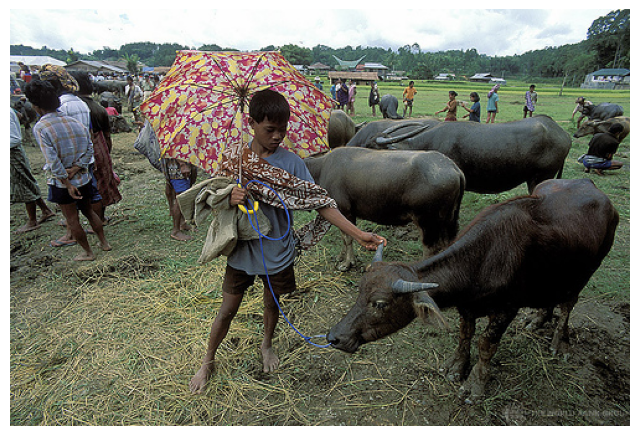

In [102]:
# Get an image ID from the dataset
image_ids = coco.getImgIds()
img_id = image_ids[2]

# Load image using OpenCV
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(images_dir, img_info['file_name'])
image = cv2.imread(img_path)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

In [103]:
image = cv2.resize(image, input_size)

# Normalize pixel values to be in the range [0, 1]
image = image / 255.0

# Print statistics about normalized image
print(f"Normalized Image Stats - Min: {np.min(image)}, Max: {np.max(image)}")

Normalized Image Stats - Min: 0.0, Max: 1.0


In [105]:
# Display the image using matplotlib
#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.axis('off')  # Turn off axis labels
#plt.show()


array([[[0.95686275, 0.94901961, 0.90980392],
        [0.98431373, 0.98039216, 0.94117647],
        [0.97647059, 0.98431373, 0.94901961],
        ...,
        [0.32156863, 0.3372549 , 0.27058824],
        [0.29803922, 0.3254902 , 0.25882353],
        [0.30196078, 0.32941176, 0.27058824]],

       [[0.97647059, 0.97254902, 0.92941176],
        [0.98431373, 0.98431373, 0.94117647],
        [0.98039216, 0.98823529, 0.94901961],
        ...,
        [0.29019608, 0.30588235, 0.23529412],
        [0.25882353, 0.28235294, 0.22745098],
        [0.23137255, 0.25882353, 0.21568627]],

       [[0.98039216, 0.98823529, 0.94509804],
        [0.97254902, 0.98039216, 0.9372549 ],
        [0.97254902, 0.98431373, 0.94509804],
        ...,
        [0.2627451 , 0.26666667, 0.20784314],
        [0.25882353, 0.2745098 , 0.22352941],
        [0.20784314, 0.23137255, 0.19215686]],

       ...,

       [[0.27843137, 0.31372549, 0.25098039],
        [0.27058824, 0.32941176, 0.28627451],
        [0.28627451, 0